#### Imports & Downloads

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
import vectorize_functions

from sklearn.metrics import mean_squared_error
import time
import optuna

from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances
from typing import Tuple
from sklearn.metrics import log_loss
from optuna.samplers import TPESampler

### Einladen der vektorisierten Daten - TFIDF

In [2]:
X_train, X_test, y_train, y_test = vectorize_functions.vectorize_ft()

In [3]:
positive = np.count_nonzero(y_train == 1)
negative = np.count_nonzero(y_train == 0)
print("Train")
print("- Positive:", positive)
print("- Negative:", negative)
print("- Verhältnis:", negative / positive)

positive = np.count_nonzero(y_test == 1)
negative = np.count_nonzero(y_test == 0)
print("Test")
print("- Positive:", positive)
print("- Negative:", negative)
print("- Verhältnis:", negative / positive)

Train
- Positive: 1270
- Negative: 18084
- Verhältnis: 14.239370078740157
Test
- Positive: 541
- Negative: 7754
- Verhältnis: 14.33271719038817


In [4]:
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (19354, 100)
y_train shape (19354,)
X_test shape (8295, 100)
y_test shape (8295,)


### 2. Ensemble Models

In [5]:
evaluation = pd.DataFrame(
    columns=["model", "variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc", "test_prec",
             "test_rec", "test_f1"])

In [6]:
def add_to_eval_df(model, model_name, variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, variant, train_acc, train_precision, train_recall, train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [7]:
def evaluate_model(model, x_test, y_test, sampling_method):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'{sampling_method} model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### 2.1 Bagging

##### 2.1.1 RandomForest

###### RandomForest no tuning

In [8]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

none model accuracy for classification is = 93.47%
------------------------------------------------
Confusion Matrix:
      0  1
0  7746  8
1   534  7
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.47      0.01      0.03       541

    accuracy                           0.93      8295
   macro avg       0.70      0.51      0.50      8295
weighted avg       0.90      0.93      0.90      8295



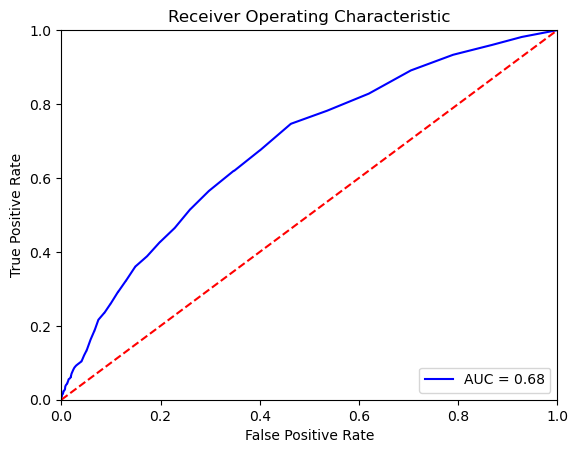

In [9]:
evaluate_model(rf, X_test, y_test, "none")
add_to_eval_df(rf, "RandomForestClassifier", "clean", X_train, y_train, X_test, y_test)

In [10]:
cv = cross_val_score(rf, X_train, y_train, cv=10, scoring='f1', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.000) total time=  37.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   37.7s remaining:    0.0s


[CV] END ................................ score: (test=0.000) total time=   7.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.8s remaining:    0.0s


[CV] END ................................ score: (test=0.000) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   51.7s remaining:    0.0s


[CV] END ................................ score: (test=0.000) total time=   7.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   58.8s remaining:    0.0s


[CV] END ................................ score: (test=0.031) total time=   7.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s


[CV] END ................................ score: (test=0.000) total time=   7.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.2min remaining:    0.0s


[CV] END ................................ score: (test=0.031) total time=   6.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV] END ................................ score: (test=0.015) total time=   7.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV] END ................................ score: (test=0.000) total time=   6.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


[CV] END ................................ score: (test=0.046) total time=   7.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min finished


In [11]:
np.mean(cv)

0.012260894321963025

###### RandomForest tuning (GridSearchCV)

In [12]:
# todo

###### RandomForest tuning (RandomizedSearchCV)

In [13]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [9, 11, 13],
}

In [14]:
random_search = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),
                                   param_grid,
                                   scoring='f1',
                                   verbose=10)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=6, max_features=log2, max_leaf_nodes=9, n_estimators=250
[CV 1/5; 1/10] END max_depth=6, max_features=log2, max_leaf_nodes=9, n_estimators=250;, score=0.000 total time=   3.5s
[CV 2/5; 1/10] START max_depth=6, max_features=log2, max_leaf_nodes=9, n_estimators=250
[CV 2/5; 1/10] END max_depth=6, max_features=log2, max_leaf_nodes=9, n_estimators=250;, score=0.000 total time=   4.2s
[CV 3/5; 1/10] START max_depth=6, max_features=log2, max_leaf_nodes=9, n_estimators=250
[CV 3/5; 1/10] END max_depth=6, max_features=log2, max_leaf_nodes=9, n_estimators=250;, score=0.000 total time=   4.4s
[CV 4/5; 1/10] START max_depth=6, max_features=log2, max_leaf_nodes=9, n_estimators=250
[CV 4/5; 1/10] END max_depth=6, max_features=log2, max_leaf_nodes=9, n_estimators=250;, score=0.000 total time=   3.2s
[CV 5/5; 1/10] START max_depth=6, max_features=log2, max_leaf_nodes=9, n_estimators=250
[CV 5/5; 1/10] END max_

RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1', verbose=10)

In [15]:
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=6, max_features='log2', max_leaf_nodes=9,
                       n_estimators=250, n_jobs=-1)


In [16]:
rf_tuned = RandomForestClassifier(**random_search.best_params_)
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features='log2', max_leaf_nodes=9,
                       n_estimators=250)

none model accuracy for classification is = 93.48%
------------------------------------------------
Confusion Matrix:
      0  1
0  7754  0
1   541  0
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      7754
           1       0.00      0.00      0.00       541

    accuracy                           0.93      8295
   macro avg       0.47      0.50      0.48      8295
weighted avg       0.87      0.93      0.90      8295



C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


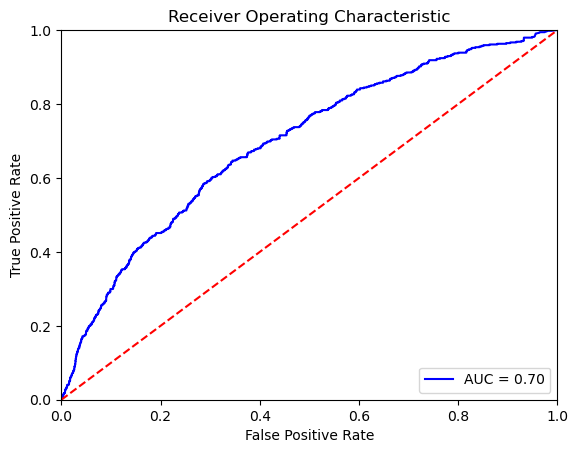

C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
evaluate_model(rf_tuned, X_test, y_test, "none")
add_to_eval_df(rf_tuned, "RandomForestClassifier-tuned-rand", "clean", X_train, y_train, X_test, y_test)

###### RandomForest tuning (optuna)
https://gist.github.com/shamilnabiyev/c1b6e23444a949bc45243eab445a3806

In [18]:
# todo: überarbeiten, callback hinzufügen wie bei xgboost optuna tuning, mehr trials

In [19]:
def objective(trial):
    # Number of trees in random forest
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=500, step=100)

    # Number of features to consider at every split
    max_features = trial.suggest_categorical(name="max_features", choices=['auto', 'sqrt'])

    # Maximum number of levels in tree
    max_depth = trial.suggest_int(name="max_depth", low=10, high=110, step=20)

    # Minimum number of samples required to split a node
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=10, step=2)

    # Minimum number of samples required at each leaf node
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)

    params = {
        "n_estimators": n_estimators,
        "max_features": max_features,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf
    }
    model = RandomForestClassifier(random_state=42, **params)

    cv_score = cross_val_score(model, X_train, y_train, n_jobs=4, cv=5, scoring='f1')
    mean_cv_accuracy = cv_score.mean()
    return mean_cv_accuracy

# study = optuna.create_study()
# study.optimize(objective, n_trials=5)

best_model = RandomForestClassifier(random_state=42, **study.best_params)
best_model.fit(X_train, y_train)

evaluate_model(best_model, X_test, y_test, "none")
add_to_eval_df(best_model, "RandomForestClassifier-tuned-optuna", "clean", X_train, y_train, X_test, y_test)

##### 2.1.2 BalancedRandomForest untuned

###### BalancedRandomForest no tuning

In [20]:
brf = BalancedRandomForestClassifier(n_jobs=-1)
brf.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

BalancedRandomForestClassifier(n_jobs=-1)

none model accuracy for classification is = 71.57%
------------------------------------------------
Confusion Matrix:
      0     1
0  5587  2167
1   191   350
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.72      0.83      7754
           1       0.14      0.65      0.23       541

    accuracy                           0.72      8295
   macro avg       0.55      0.68      0.53      8295
weighted avg       0.91      0.72      0.79      8295



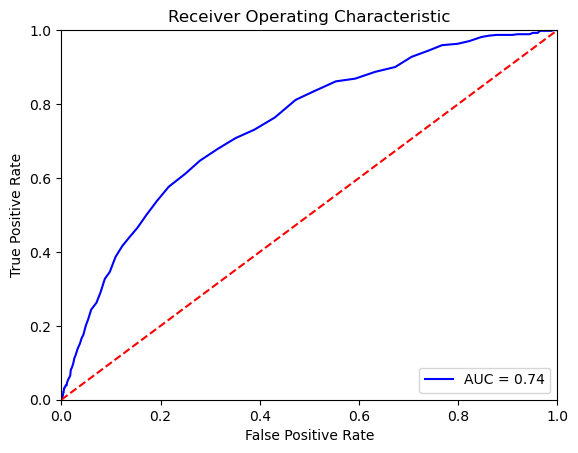

In [21]:
evaluate_model(brf, X_test, y_test, "none")
add_to_eval_df(brf, "BalancedRandomForestClassifier", "clean", X_train, y_train, X_test, y_test)

In [22]:
cv = cross_val_score(brf, X_train, y_train, cv=10, scoring='f1', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] START .....................................................................
[CV] END ................................ score: (test=0.203) total time=   1.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.224) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.214) total time=   0.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.219) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.1s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.247) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.0s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.204) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    5.9s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.222) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    6.8s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.246) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.7s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.238) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.6s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.229) total time=   0.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.5s finished


In [23]:
np.mean(cv)

0.22470758608864672

###### BalancedRandomForest tuning (RandomizedSearchCV)

In [24]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [9, 11, 13],
}

In [25]:
random_search = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                                   param_grid,
                                   scoring='f1',
                                   verbose=0)
random_search.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: 

RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1')

In [26]:
brf_tuned = BalancedRandomForestClassifier(**random_search.best_params_, verbose=0)
brf_tuned.fit(X_train, y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklear

BalancedRandomForestClassifier(max_depth=9, max_features='log2',
                               max_leaf_nodes=9, n_estimators=250)

none model accuracy for classification is = 71.22%
------------------------------------------------
Confusion Matrix:
      0     1
0  5576  2178
1   209   332
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82      7754
           1       0.13      0.61      0.22       541

    accuracy                           0.71      8295
   macro avg       0.55      0.67      0.52      8295
weighted avg       0.91      0.71      0.78      8295



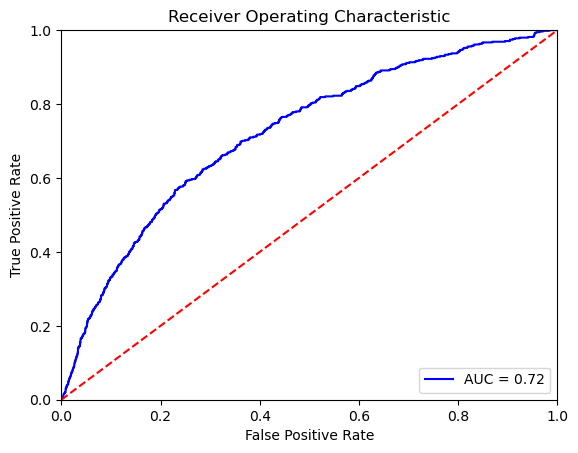

In [27]:
evaluate_model(brf_tuned, X_test, y_test, "none")
add_to_eval_df(brf, "BalancedRandomForestClassifier-tuned", "clean", X_train, y_train, X_test, y_test)

#### 2.2 Boosting

##### 2.2.1 XGBClassifier

In [28]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 93.44%
------------------------------------------------
Confusion Matrix:
      0   1
0  7721  33
1   511  30
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.48      0.06      0.10       541

    accuracy                           0.93      8295
   macro avg       0.71      0.53      0.53      8295
weighted avg       0.91      0.93      0.91      8295



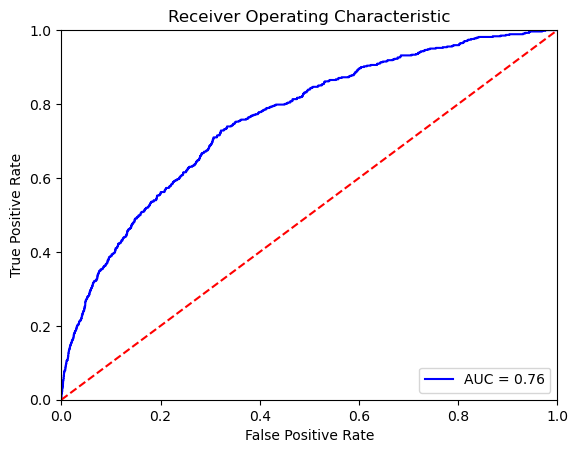

In [29]:
evaluate_model(xgb, X_test, y_test, "none")
add_to_eval_df(xgb, "XGBClassifier", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (GridSearchCV)
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Tuning mit GridSearchCV dauert bei großer param-Liste sehr lange, daher einzelne Schritte mit jeweils nur 1 bis max. 2 params


In [30]:
param_test = {
    'learning_rate': [0.1, 0.01, 0.001],
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.32039688186494825, {'learning_rate': 0.1})

none model accuracy for classification is = 93.59%
------------------------------------------------
Confusion Matrix:
      0   1
0  7751   3
1   529  12
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.80      0.02      0.04       541

    accuracy                           0.94      8295
   macro avg       0.87      0.51      0.50      8295
weighted avg       0.93      0.94      0.91      8295



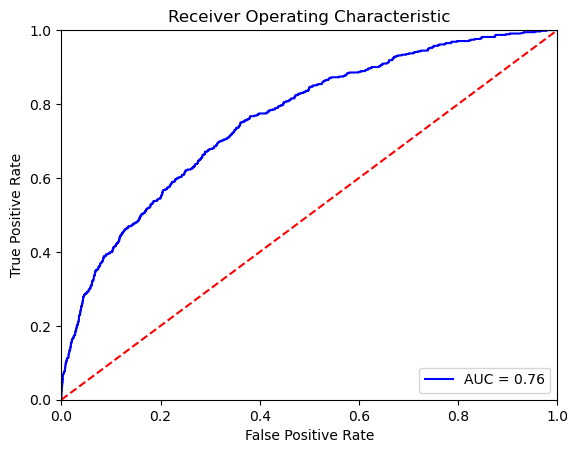

In [31]:
xgb_test = XGBClassifier(learning_rate=0.1)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [32]:
param_test = {
    'n_estimators': range(100, 250, 50),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.37817637241282653, {'n_estimators': 200})

none model accuracy for classification is = 93.57%
------------------------------------------------
Confusion Matrix:
      0   1
0  7747   7
1   526  15
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.68      0.03      0.05       541

    accuracy                           0.94      8295
   macro avg       0.81      0.51      0.51      8295
weighted avg       0.92      0.94      0.91      8295



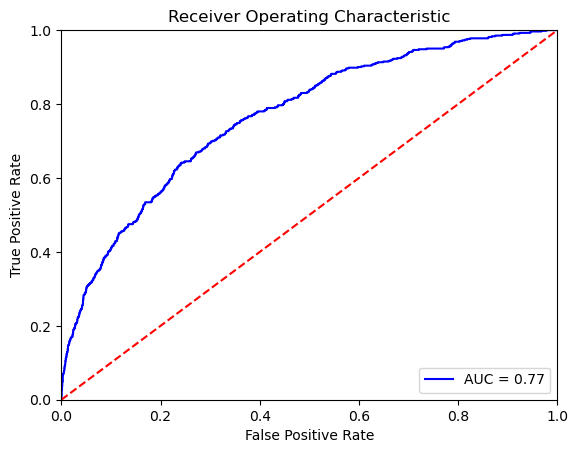

In [33]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [34]:
param_test = {
    'max_depth': range(5, 13, 2),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4298347587940351, {'max_depth': 11})

none model accuracy for classification is = 93.36%
------------------------------------------------
Confusion Matrix:
      0   1
0  7721  33
1   518  23
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.41      0.04      0.08       541

    accuracy                           0.93      8295
   macro avg       0.67      0.52      0.52      8295
weighted avg       0.90      0.93      0.91      8295



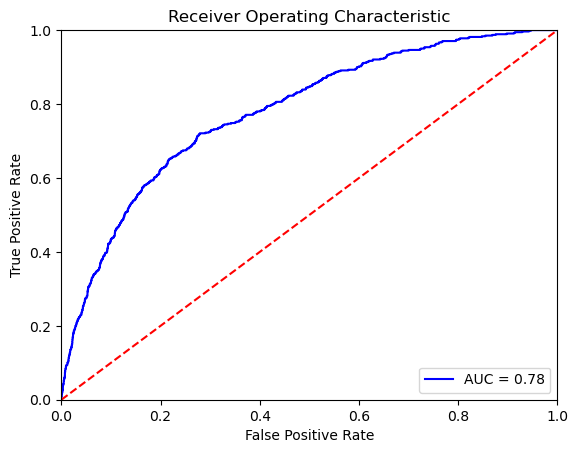

In [35]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [36]:
param_test = {
    'subsample': [0.5, 0.7, 1]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'subsample': 0.7})

none model accuracy for classification is = 93.38%
------------------------------------------------
Confusion Matrix:
      0   1
0  7720  34
1   515  26
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.43      0.05      0.09       541

    accuracy                           0.93      8295
   macro avg       0.69      0.52      0.53      8295
weighted avg       0.90      0.93      0.91      8295



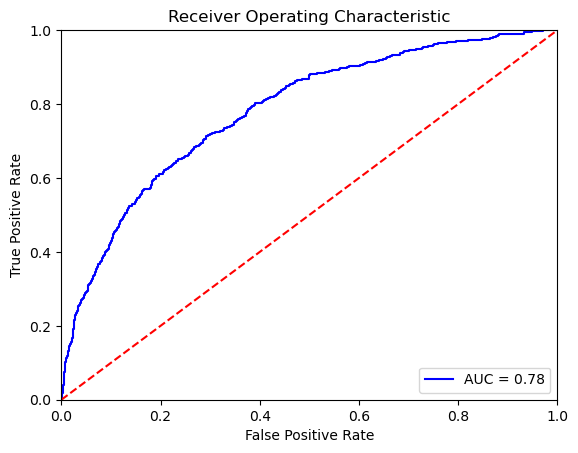

In [37]:
xgb_test = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7)
xgb_test.fit(X_train, y_train)
evaluate_model(xgb_test, X_test, y_test, "none")

In [38]:
param_test = {
    'min_child_weight': range(1, 6, 2),
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'min_child_weight': 1}) <== kein Einfluss auf Modellperformance

In [39]:
param_test = {
    'gamma': [i / 10.0 for i in range(0, 5)],
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

# gsearch.fit(X_train, y_train)
# gsearch.best_score_, gsearch.best_params_

# (0.4406213750099548, {'gamma': 0.0}) <== kein Einfluss auf Modellperformance

In [40]:
param_test = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

gsearch.fit(X_train, y_train)
gsearch.best_score_, gsearch.best_params_

# (0.44114103318625436, {'reg_alpha': 0.01})

Fitting 5 folds for each of 5 candidates, totalling 25 fits


(0.05977604244068091, {'reg_alpha': 1e-05})

In [41]:
param_test = {
    'reg_alpha': [0.005, 0.01, 0.015, 0.02, 0.025]
}
gsearch = GridSearchCV(estimator=XGBClassifier(
    seed=42,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=11,
    subsample=0.7,
), param_grid=param_test, scoring='f1', n_jobs=-1, cv=5, verbose=1)

gsearch.fit(X_train, y_train)
gsearch.best_score_, gsearch.best_params_

# # (0.44114103318625436, {'reg_alpha': 0.01})

Fitting 5 folds for each of 5 candidates, totalling 25 fits


(0.058391254121843164, {'reg_alpha': 0.02})

In [42]:
xgb_tuned_grid = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=11, subsample=0.7, reg_alpha=0.01)
xgb_tuned_grid.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 93.43%
------------------------------------------------
Confusion Matrix:
      0   1
0  7722  32
1   513  28
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.47      0.05      0.09       541

    accuracy                           0.93      8295
   macro avg       0.70      0.52      0.53      8295
weighted avg       0.91      0.93      0.91      8295



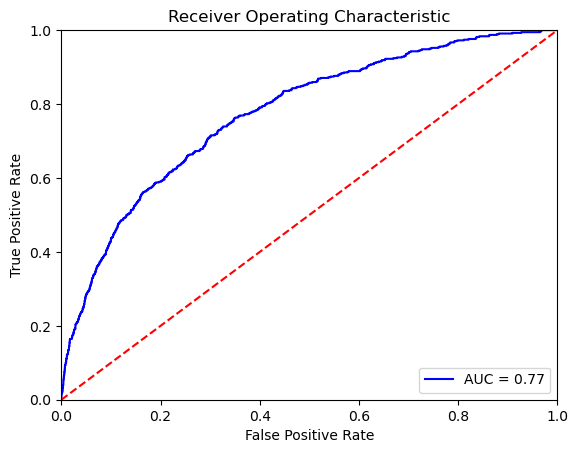

In [43]:
evaluate_model(xgb_tuned_grid, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_grid, "XGBClassifier-tuned-grid", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (RandomizedSearchCV)
Vergleich Modellperformance zwischen GridSearchCV <-> RandomizedSearchCV

In [44]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': range(100, 250, 50),
    'max_depth': range(5, 13, 2),
    'subsample': [0.5, 0.7, 1],
    'min_child_weight': range(1, 6, 2),
    'gamma': [i / 10.0 for i in range(0, 5)],
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100],
}

In [45]:
rsearch = RandomizedSearchCV(XGBClassifier(n_jobs=-1),
                             param_grid,
                             scoring='f1',
                             verbose=1,
                             cv=5,
                             )

In [46]:
rsearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.1, 0.01, 0.001],
                                        'max_depth': range(5, 13, 2),
                                        'min_child_weight': range(1, 6, 2),
                                        'n_estimators': range(100, 250, 50),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 100],
                                        'subsample': [0.5, 0.7, 1]},
                   scoring='f1', verbose=1)

In [47]:
rsearch.best_score_, rsearch.best_params_

(0.059315784507333304,
 {'subsample': 0.7,
  'reg_alpha': 0.1,
  'n_estimators': 200,
  'min_child_weight': 5,
  'max_depth': 7,
  'learning_rate': 0.1,
  'gamma': 0.1})

In [48]:
xgb_tuned_rand = XGBClassifier(**rsearch.best_params_, n_jobs=-1)
xgb_tuned_rand.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

none model accuracy for classification is = 93.63%
------------------------------------------------
Confusion Matrix:
      0   1
0  7741  13
1   515  26
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.67      0.05      0.09       541

    accuracy                           0.94      8295
   macro avg       0.80      0.52      0.53      8295
weighted avg       0.92      0.94      0.91      8295



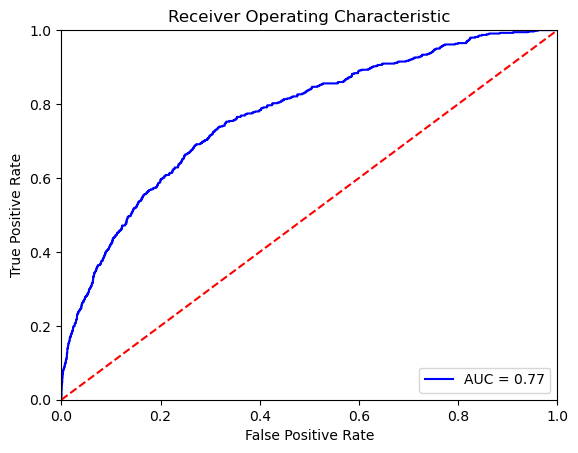

In [49]:
evaluate_model(xgb_tuned_rand, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_rand, "XGBClassifier-tuned-rand", "clean", X_train, y_train, X_test, y_test)

###### XGBClassifier tuning (optuna)
https://randomrealizations.com/posts/xgboost-parameter-tuning-with-optuna/

https://www.kaggle.com/code/rzatemizel/optuna-xgboostcv-integration-with-pruning#Intro

def balancedlogloss(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    ''' balanced log loss metric.'''
    y = dtrain.get_label()
    target_mean = y.mean()
    w0 = 1 / (1 - target_mean)
    w1 = 1 / target_mean
    sample_weight = [w0 if y == 0 else w1 for y in y]
    loss = log_loss(y, predt, eps=1e-15, sample_weight=sample_weight)

    return 'balancedlogloss', loss

def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)

    param = {

        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 0.8),
        'scale_pos_weight': 509 / 108,
        'random_state': 42,
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 16)
        param["eta"] = trial.suggest_float("eta", 1e-3, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-balancedlogloss")
    history = xgb.cv(param,
                     dtrain,
                     stratified=True,
                     nfold=5,
                     num_boost_round=10000,
                     early_stopping_rounds=50,
                     custom_metric=balancedlogloss,
                     seed=42,
                     callbacks=[pruning_callback])

    mean_balancedlogloss = history["test-balancedlogloss-mean"].values[-1]
    trial.set_user_attr("n_estimators", len(history))
    return mean_balancedlogloss


sampler = TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
study = optuna.create_study(sampler=sampler, pruner=pruner, direction="minimize")
study.optimize(objective, n_trials=5)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))

plot_optimization_history(study)
plot_param_importances(study)

xgb_tuned_optuna = XGBClassifier(**study.best_trial.params)
evaluate_model(xgb_tuned_optuna, X_test, y_test, "none")
add_to_eval_df(xgb_tuned_optuna, "XGBClassifier-tuned-optuna", "clean", X_train, y_train, X_test, y_test)

##### 2.2.1 CatBoostClassifier

In [51]:
cat = CatBoostClassifier(iterations=100,
                         depth=5,
                         learning_rate=0.1,
                         loss_function='Logloss',
                         verbose=True)
cat.fit(X_train, y_train)

0:	learn: 0.5856642	total: 149ms	remaining: 14.8s
1:	learn: 0.5012806	total: 162ms	remaining: 7.96s
2:	learn: 0.4381550	total: 176ms	remaining: 5.7s
3:	learn: 0.3901347	total: 189ms	remaining: 4.54s
4:	learn: 0.3539525	total: 202ms	remaining: 3.84s
5:	learn: 0.3272503	total: 215ms	remaining: 3.37s
6:	learn: 0.3061654	total: 228ms	remaining: 3.03s
7:	learn: 0.2906491	total: 241ms	remaining: 2.77s
8:	learn: 0.2784001	total: 253ms	remaining: 2.56s
9:	learn: 0.2687105	total: 266ms	remaining: 2.39s
10:	learn: 0.2612567	total: 378ms	remaining: 3.06s
11:	learn: 0.2552780	total: 398ms	remaining: 2.92s
12:	learn: 0.2502367	total: 411ms	remaining: 2.75s
13:	learn: 0.2461995	total: 424ms	remaining: 2.61s
14:	learn: 0.2428179	total: 437ms	remaining: 2.48s
15:	learn: 0.2405422	total: 450ms	remaining: 2.36s
16:	learn: 0.2381373	total: 463ms	remaining: 2.26s
17:	learn: 0.2360229	total: 477ms	remaining: 2.17s
18:	learn: 0.2344848	total: 493ms	remaining: 2.1s
19:	learn: 0.2330565	total: 507ms	remaining

none model accuracy for classification is = 93.48%
------------------------------------------------
Confusion Matrix:
      0  1
0  7754  0
1   541  0
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      7754
           1       0.00      0.00      0.00       541

    accuracy                           0.93      8295
   macro avg       0.47      0.50      0.48      8295
weighted avg       0.87      0.93      0.90      8295



C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


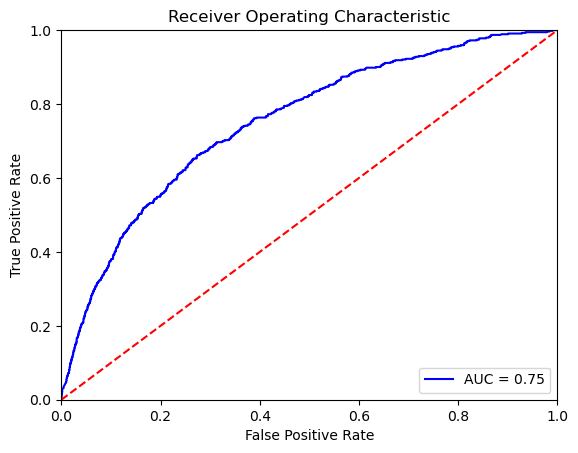

C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
evaluate_model(cat, X_test, y_test, "none")
add_to_eval_df(cat, "CatBoostClassifier", "clean", X_train, y_train, X_test, y_test)

##### 2.2.1 LGBMClassifier

In [53]:
light = LGBMClassifier()
light.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1270, number of negative: 18084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 19354, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065620 -> initscore=-2.656011
[LightGBM] [Info] Start training from score -2.656011


LGBMClassifier()

none model accuracy for classification is = 93.59%
------------------------------------------------
Confusion Matrix:
      0   1
0  7746   8
1   524  17
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.68      0.03      0.06       541

    accuracy                           0.94      8295
   macro avg       0.81      0.52      0.51      8295
weighted avg       0.92      0.94      0.91      8295



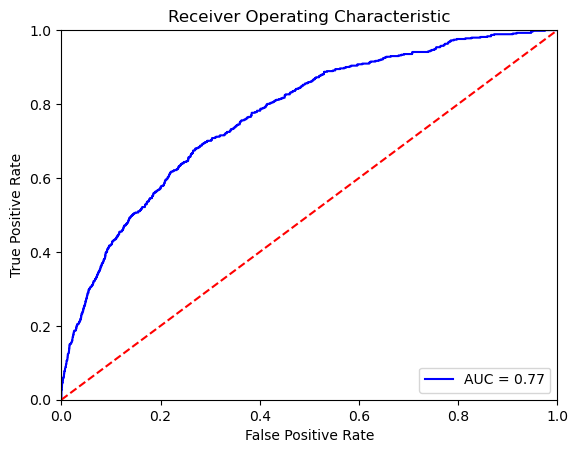

In [54]:
evaluate_model(light, X_test, y_test, "none")
add_to_eval_df(light, "LGBMClassifier", "clean", X_train, y_train, X_test, y_test)

#### 2.3 Stacking

##### 2.3.1 Stacking: RandomForest + LinearSVC

In [55]:
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', LinearSVC(random_state=42))
]
stack = StackingClassifier(estimators=base_models, n_jobs=-1)

In [56]:
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svc', LinearSVC(random_state=42))],
                   n_jobs=-1)

none model accuracy for classification is = 93.44%
------------------------------------------------
Confusion Matrix:
      0  1
0  7747  7
1   537  4
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.36      0.01      0.01       541

    accuracy                           0.93      8295
   macro avg       0.65      0.50      0.49      8295
weighted avg       0.90      0.93      0.90      8295



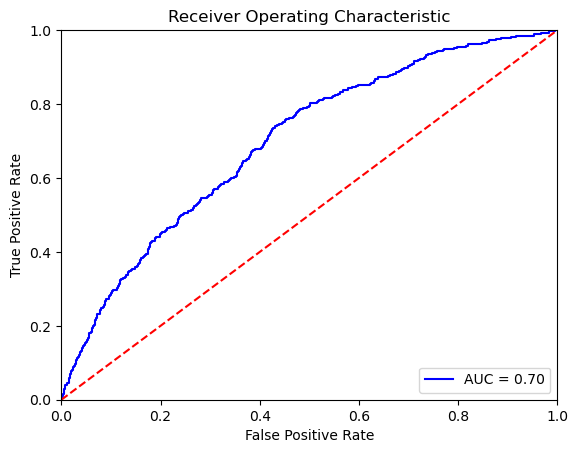

In [57]:
evaluate_model(stack, X_test, y_test, "none")
add_to_eval_df(stack, "StackingClassifier", "clean", X_train, y_train, X_test, y_test)

Vergleich: SVC

In [58]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC()

In [59]:
evaluate_model(svc, X_test, y_test, "none")
add_to_eval_df(svc, "LinearSVC", "clean", X_train, y_train, X_test, y_test)

none model accuracy for classification is = 93.48%
------------------------------------------------
Confusion Matrix:
      0  1
0  7754  0
1   541  0
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      7754
           1       0.00      0.00      0.00       541

    accuracy                           0.93      8295
   macro avg       0.47      0.50      0.48      8295
weighted avg       0.87      0.93      0.90      8295



C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

#### Model comparision

In [60]:
evaluation.drop_duplicates(inplace=True)

In [61]:
evaluation.sort_values(by=["test_prec"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
8,LGBMClassifier,clean,0.970239,1.000000,0.546457,0.706721,0.935865,0.680000,0.031423,0.060071
6,XGBClassifier-tuned-rand,clean,0.989976,1.000000,0.847244,0.917306,0.936347,0.666667,0.048059,0.089655
4,XGBClassifier,clean,0.996435,1.000000,0.945669,0.972076,0.934418,0.476190,0.055453,0.099338
0,RandomForestClassifier,clean,0.999897,1.000000,0.998425,0.999212,0.934659,0.466667,0.012939,0.025180
5,XGBClassifier-tuned-grid,clean,0.999742,1.000000,0.996063,0.998028,0.934298,0.466667,0.051756,0.093178
9,StackingClassifier,clean,0.982898,1.000000,0.739370,0.850158,0.934418,0.363636,0.007394,0.014493
2,BalancedRandomForestClassifier,clean,0.798491,0.245648,1.000000,0.394410,0.715732,0.139054,0.646950,0.228908
3,BalancedRandomForestClassifier-tuned,clean,0.798491,0.245648,1.000000,0.394410,0.715732,0.139054,0.646950,0.228908
1,RandomForestClassifier-tuned-rand,clean,0.934380,0.000000,0.000000,0.000000,0.934780,0.000000,0.000000,0.000000
7,CatBoostClassifier,clean,0.934639,1.000000,0.003937,0.007843,0.934780,0.000000,0.000000,0.000000


In [62]:
evaluation.sort_values(by=["test_rec"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
2,BalancedRandomForestClassifier,clean,0.798491,0.245648,1.000000,0.394410,0.715732,0.139054,0.646950,0.228908
3,BalancedRandomForestClassifier-tuned,clean,0.798491,0.245648,1.000000,0.394410,0.715732,0.139054,0.646950,0.228908
4,XGBClassifier,clean,0.996435,1.000000,0.945669,0.972076,0.934418,0.476190,0.055453,0.099338
5,XGBClassifier-tuned-grid,clean,0.999742,1.000000,0.996063,0.998028,0.934298,0.466667,0.051756,0.093178
6,XGBClassifier-tuned-rand,clean,0.989976,1.000000,0.847244,0.917306,0.936347,0.666667,0.048059,0.089655
8,LGBMClassifier,clean,0.970239,1.000000,0.546457,0.706721,0.935865,0.680000,0.031423,0.060071
0,RandomForestClassifier,clean,0.999897,1.000000,0.998425,0.999212,0.934659,0.466667,0.012939,0.025180
9,StackingClassifier,clean,0.982898,1.000000,0.739370,0.850158,0.934418,0.363636,0.007394,0.014493
1,RandomForestClassifier-tuned-rand,clean,0.934380,0.000000,0.000000,0.000000,0.934780,0.000000,0.000000,0.000000
7,CatBoostClassifier,clean,0.934639,1.000000,0.003937,0.007843,0.934780,0.000000,0.000000,0.000000


In [63]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
2,BalancedRandomForestClassifier,clean,0.798491,0.245648,1.000000,0.394410,0.715732,0.139054,0.646950,0.228908
3,BalancedRandomForestClassifier-tuned,clean,0.798491,0.245648,1.000000,0.394410,0.715732,0.139054,0.646950,0.228908
4,XGBClassifier,clean,0.996435,1.000000,0.945669,0.972076,0.934418,0.476190,0.055453,0.099338
5,XGBClassifier-tuned-grid,clean,0.999742,1.000000,0.996063,0.998028,0.934298,0.466667,0.051756,0.093178
6,XGBClassifier-tuned-rand,clean,0.989976,1.000000,0.847244,0.917306,0.936347,0.666667,0.048059,0.089655
8,LGBMClassifier,clean,0.970239,1.000000,0.546457,0.706721,0.935865,0.680000,0.031423,0.060071
0,RandomForestClassifier,clean,0.999897,1.000000,0.998425,0.999212,0.934659,0.466667,0.012939,0.025180
9,StackingClassifier,clean,0.982898,1.000000,0.739370,0.850158,0.934418,0.363636,0.007394,0.014493
1,RandomForestClassifier-tuned-rand,clean,0.934380,0.000000,0.000000,0.000000,0.934780,0.000000,0.000000,0.000000
7,CatBoostClassifier,clean,0.934639,1.000000,0.003937,0.007843,0.934780,0.000000,0.000000,0.000000


none model accuracy for classification is = 93.47%
------------------------------------------------
Confusion Matrix:
      0  1
0  7746  8
1   534  7
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7754
           1       0.47      0.01      0.03       541

    accuracy                           0.93      8295
   macro avg       0.70      0.51      0.50      8295
weighted avg       0.90      0.93      0.90      8295



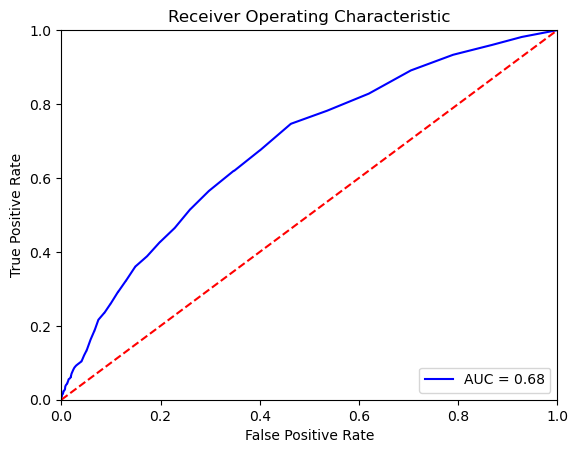

In [64]:
evaluate_model(rf, X_test, y_test, "none")

#### Auswertung

- Performance deutlich unter TF-IDF und BOW
- wahrscheinlich Vektorisierungmethode fehlerhaft / falsche Parameter